In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

## Задание 1

Вернемся к набору данных о видеоиграх.

Ответьте на следующие вопросы:

1) Как критики относятся к спортивным играм?  
2) Критикам нравятся больше игры на PC или на PS4?  
3) Критикам больше нравятся стрелялки или стратегии?

Для каждого вопроса:

- сформулируйте нулевую и альтернативную гипотезы;
- выберите пороговый уровень статистической значимости;
- опишите полученные результаты статистического теста.

In [2]:
df_videogames = pd.read_csv('video_games_sales.csv')
df_videogames[:5]

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,...,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,...,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,...,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,...,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg
3,4,PlayerUnknown's Battlegrounds,playerunknowns-battlegrounds,Shooter,NaN,PC,PUBG Corporation,PUBG Corporation,NaN,NaN,...,NaN,NaN,NaN,NaN,2017.0,13th Nov 18,http://www.vgchartz.com/game/215988/playerunkn...,1,NaN,/games/boxart/full_8052843AmericaFrontccc.jpg
4,5,Wii Sports Resort,wii-sports-resort,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,8.0,...,NaN,NaN,NaN,NaN,2009.0,NaN,http://www.vgchartz.com/game/24656/wii-sports-...,1,8.8,/games/boxart/full_7295041AmericaFrontccc.jpg


### 1) Как критики относятся к спортивным играм?

Проверим является ли распределение значений отзывов критивов спортивных игр нормальным.

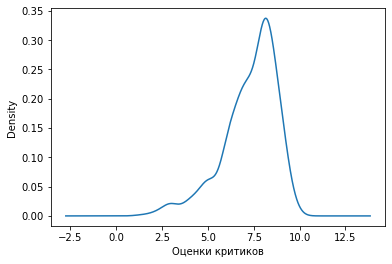

Распределение значений отзывов критивов спортивных игр не является нормальным


In [3]:
df_sport_games_critics = df_videogames[df_videogames.Genre == 'Sports']['Critic_Score'].dropna()
df_sport_games_critics.plot(kind='density')
plt.xlabel('Оценки критиков')
plt.show()

stat, p = scipy.stats.shapiro(df_sport_games_critics)
alpha = 0.05

if p < alpha:
    print('Распределение значений отзывов критивов спортивных игр не является нормальным')
else:
    print('Распределение значений отзывов критивов спортивных игр нормальное')

Попробуем привести выборку к нормальному распределению с помощью бутстрапа.

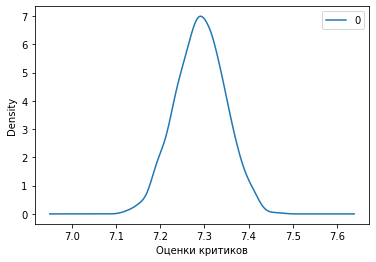

Распределение значений отзывов критивов спортивных игр нормальное


In [4]:
sport_games_critics_bootstrap_means = []
for _ in range(1000):
    sport_games_critics_bootstrap_means.append(df_sport_games_critics.sample(frac=1, replace=True).mean())
df_sport_games_critics_bootstrap_means = pd.DataFrame(sport_games_critics_bootstrap_means)
df_sport_games_critics_bootstrap_means.plot(kind='density')
plt.xlabel('Оценки критиков')
plt.show()

stat, p = scipy.stats.shapiro(sport_games_critics_bootstrap_means)
alpha = 0.05

if p < alpha:
    print('Распределение значений отзывов критивов спортивных игр не является нормальным')
else:
    print('Распределение значений отзывов критивов спортивных игр нормальное')

После приведения значений к нормальному распределению используем одновыборочный тест Стьюдента для проверки наших гипотез.

Предположим, что если критикам нравятся спортивные игры, то средняя оценка должна быть не менее 8.

H0 - Рейтинг спортивных игр у критиков не менее 8  
H1 - Рейтинг спортивных игр у критиков менее 8

Используем односторонний тест, так как интересуют значения только с одной стороны.

In [5]:
alpha = 0.05

t, p = scipy.stats.ttest_1samp(sport_games_critics_bootstrap_means, 8)

if p/2 < alpha and t > 0:
    print('Критикам нравятся спортивные игры, ставят оценки больше 8')
else:
    print('Критикам не нравятся спортивные игры, ставят оценки меньше 8')

Критикам не нравятся спортивные игры, ставят оценки меньше 8


### 2) Критикам нравятся больше игры на PC или на PS4?

Так как сраниваем 2 выборки не имеющего нормального распределения самым адекватным критерием для оценки гипотез будет U-критерий Манна-Уитни для независимых выборок.

H0 - Оценки критиков для PC и PS4 не отличаются  
H1 - Оценки критиков для PC и PS4 различны

Будем выполнять двусторонний тест, так как интересуют отличия с двух сторон плотности распределения значений.

In [6]:
df_critics_pc_ps4 = (df_videogames[df_videogames.Platform.isin(['PC', 'PS4'])][['Platform', 'Critic_Score']]
                     .dropna())
df_critics_pc_ps4[:5]

,Platform,Critic_Score
9,PC,10.0
20,PS4,9.7
36,PC,9.3
45,PS4,9.8
50,PS4,8.0


In [7]:
stat, p = scipy.stats.mannwhitneyu(df_critics_pc_ps4[df_critics_pc_ps4.Platform == 'PC'].Critic_Score,
                                   df_critics_pc_ps4[df_critics_pc_ps4.Platform == 'PS4'].Critic_Score,
                                   alternative='two-sided')

ps4_critic_mean = df_critics_pc_ps4[df_critics_pc_ps4.Platform == 'PS4'].Critic_Score.mean()
pc_critic_mean = df_critics_pc_ps4[df_critics_pc_ps4.Platform == 'PC'].Critic_Score.mean()

alpha = 0.05

if p < alpha:
    print('Оценки критиков для PC и PS4 различны')
    if ps4_critic_mean > pc_critic_mean:
        print('Критикам больше нравятся игры для PS4')
    else:
        print('Критикам больше нравятся игры для PC')
else:
    print('Оценки критиков для PC и PS4 не отличаются')

Оценки критиков для PC и PS4 различны
Критикам больше нравятся игры для PS4


### 3) Критикам больше нравятся стрелялки или стратегии?

Аналогично имеем 2 выборки не имеющие нормального распределения, самым адекватным критерием для оценки гипотез будет U-критерий Манна-Уитни для независимых выборок.

H0 - Оценки критиков между стратегиями и стрелялками не отличаются  
H1 - Оценки критиков между стратегиями и стрелялками различны

In [8]:
df_critics_shooter_strategy = (df_videogames[df_videogames.Genre.isin(['Shooter', 'Strategy'])]
                     [['Genre', 'Critic_Score']].dropna())
df_critics_shooter_strategy[:5]

,Genre,Critic_Score
36,Shooter,9.3
40,Shooter,8.7
41,Shooter,8.8
43,Shooter,9.6
49,Shooter,9.5


In [9]:
stat, p = scipy.stats.mannwhitneyu(df_critics_shooter_strategy[df_critics_shooter_strategy.Genre == 'Shooter']
                                   .Critic_Score,
                                   df_critics_shooter_strategy[df_critics_shooter_strategy.Genre == 'Strategy']
                                   .Critic_Score,
                                   alternative='two-sided')

shooter_critic_mean = (df_critics_shooter_strategy[df_critics_shooter_strategy.Genre == 'Shooter']
                       .Critic_Score.mean())
strategy_critic_mean = (df_critics_shooter_strategy[df_critics_shooter_strategy.Genre == 'Strategy']
                        .Critic_Score.mean())

alpha = 0.05

if p < alpha:
    print('Оценки критиков для PC и PS4 различны')
    if shooter_critic_mean > strategy_critic_mean:
        print('Критикам больше нравятся стратегии')
    else:
        print('Критикам больше нравятся стрелялки')
else:
    print('Оценки критиков между стратегиями и стрелялками не отличаются')

Оценки критиков между стратегиями и стрелялками не отличаются


## Задание 2

Реализуйте базовую модель логистической регрессии для классификации текстовых сообщений (используемые данные [здесь](https://github.com/obulygin/pyda_homeworks/blob/master/stat_case_study/spam.csv)) по признаку спама. Для этого:

1) Привидите весь текст к нижнему регистру;  
2) Удалите мусорные символы;  
3) Удалите стоп-слова;  
4) Привидите все слова к нормальной форме;  
5) Преобразуйте все сообщения в вектора TF-IDF. Вам поможет следующий код:  

```
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df.Message)
names = tfidf.get_feature_names()
tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=cname)
```

Можете поэкспериментировать с параметрами [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html);  
6) Разделите данные на тестовые и тренировочные в соотношении 30/70, укажите `random_state=42`. Используйте [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html);  
7) Постройте модель [логистической регрессии](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), укажите `random_state=42`, оцените ее точность на тестовых данных;  
8) Опишите результаты при помощи [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html?highlight=confusion_matrix#sklearn.metrics.confusion_matrix);  
9) Постройте датафрейм, который будет содержать все исходные тексты сообщений, классифицированные неправильно (с указанием фактического и предсказанного).

In [10]:
df_spam = pd.read_csv('spam.csv')
df_spam[:5]

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
df_spam = pd.read_csv('spam.csv')
df_spam.Category = df_spam.Category.apply(lambda value: 1 if value == 'spam' else 0)
display(df_spam[:5])
df_spam.iloc[0].Message

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

Приводим весь текст к нижнему регистру

In [12]:
df_spam.Message = df_spam.Message.apply(lambda x: x.lower())
display(df_spam[:5])
df_spam.iloc[0].Message

,Category,Message
0,0,"go until jurong point, crazy.. available only ..."
1,0,ok lar... joking wif u oni...
2,1,free entry in 2 a wkly comp to win fa cup fina...
3,0,u dun say so early hor... u c already then say...
4,0,"nah i don't think he goes to usf, he lives aro..."


'go until jurong point, crazy.. available only in bugis n great world la e buffet... cine there got amore wat...'

Удалим мусорные символы

In [13]:
df_spam.Message = df_spam.Message.apply(lambda x: re.sub(r'[\W_]', ' ', x))


stopwords_set = set(stopwords.words('english'))
df_spam.Message = (df_spam.Message
                   .apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords_set])))
display(df_spam[:5])
df_spam.iloc[0].Message

,Category,Message
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry 2 wkly comp win fa cup final tkts 2...
3,0,u dun say early hor u c already say
4,0,nah think goes usf lives around though


'go jurong point crazy available bugis n great world la e buffet cine got amore wat'

Приведем все слова к нормальной форме

In [14]:
wordnet_lemmatizer = WordNetLemmatizer()
df_spam.Message = (df_spam.Message
                   .apply(lambda x: ' '.join([wordnet_lemmatizer.lemmatize(word) for word in x.split()])))
display(df_spam[:5])
df_spam.iloc[0].Message

,Category,Message
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry 2 wkly comp win fa cup final tkts 2...
3,0,u dun say early hor u c already say
4,0,nah think go usf life around though


'go jurong point crazy available bugis n great world la e buffet cine got amore wat'

5) Преобразуйте все сообщения в вектора TF-IDF. Вам поможет следующий код:  

```
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df.Message)
names = tfidf.get_feature_names()
tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=cname)
```

Можете поэкспериментировать с параметрами [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html);  

In [15]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df_spam.Message)
names = tfidf.get_feature_names()
tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=names)
tfidf_matrix

,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,...,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,èn,ú1,〨ud
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


6) Разделите данные на тестовые и тренировочные в соотношении 30/70, укажите random_state=42. Используйте train_test_split;

In [16]:
df_tf_idf = pd.merge(df_spam[['Category']], tfidf_matrix, left_index=True, right_index=True)
df_tf_idf[:5]

,Category,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,...,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,èn,ú1,〨ud
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
X_train, X_test, y_train, y_test = train_test_split(df_tf_idf.iloc[:, 1:],
                                                    df_tf_idf['Category'], 
                                                    test_size=0.3,
                                                    random_state=42)

7) Постройте модель логистической регрессии, укажите random_state=42, оцените ее точность на тестовых данных;

In [18]:
lda = LogisticRegression(random_state=42)
lda.fit(X_train, y_train)
y_predict = lda.predict(X_test)

print('Точность предсказания:', accuracy_score(y_test, y_predict))

c:\program files\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Точность предсказания: 0.958732057416268


8) Опишите результаты при помощи [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html?highlight=confusion_matrix#sklearn.metrics.confusion_matrix);  

In [19]:
confusion_matrix(y_test, y_predict)

array([[1445,    3],
       [  66,  158]], dtype=int64)

1445 - Количество истинно-положительных результатов. Количество писем, определенных моделью как спам, и они дейсвтительно являлись спамом.

3    - кол-во ложноположительных решений. Кол-во писем, принятых за спам, но реально спамом они не являются.

66   - кол-во ложноотрицательных решений. Кол-во писем, принятых за нормальные, но реально являющиеся спамом.

158  - кол-во истинно-отрицательных решений. Кол-во писем, которые отмечены нормальными и реально таковыми являются.

9) Постройте датафрейм, который будет содержать все исходные тексты сообщений, классифицированные неправильно (с указанием фактического и предсказанного).

In [20]:
df_real_predict = pd.DataFrame(y_test)
df_real_predict['Predict_Category'] = y_predict
df_real_predict = pd.merge(df_real_predict, df_spam[['Message']], how='left', left_index=True, right_index=True)
df_real_predict.Category = df_real_predict.Category.apply(lambda value: 'spam' if value == 1 else 'ham')
df_real_predict.Predict_Category = (df_real_predict.Predict_Category
                                    .apply(lambda value: 'spam' if value == 1 else 'ham'))
df_uncorrect_predicts = df_real_predict[df_real_predict.Category != df_real_predict.Predict_Category]
df_uncorrect_predicts[:10]

,Category,Predict_Category,Message
2952,ham,spam,hey free call
881,spam,ham,reminder downloaded content already paid goto ...
1961,spam,ham,guess somebody know secretly fancy wanna find ...
3864,spam,ham,oh god found number glad text back xafter msg ...
2575,spam,ham,next amazing xxx picsfree1 video sent enjoy on...
3548,spam,ham,rock yr chik get 100 filthy film xxx pic yr ph...
2402,spam,ham,babe u want dont u baby im nasty thing 4 filth...
4527,spam,ham,want cock hubby away need real man 2 satisfy t...
15,spam,ham,xxxmobilemovieclub use credit click wap link n...
2663,spam,ham,hello darling today would love chat dont tell ...
